In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [ ]:
# 指定當前的工作資料夾
import os
# 此處為google drive中的檔案路徑,drive為之前指定的工作根目錄，要加上
os.chdir("drive/Colab Notebooks")

In [ ]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series
import numpy as np
import pandas as pd
import os
import warnings
import itertools 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm     # 一個有很多統計模型的python庫，能完成很多統計測試，資料探索以及視覺化 (藥用scipy1.2版才不會又錯誤)

In [ ]:
# load dataset 
df = read_csv('wheat_200910-201803.csv')
df['year'] = pd.DatetimeIndex(df['date']).year   # df 新增year欄位
df['month'] = pd.DatetimeIndex(df['date']).month # df 新增month欄位
print(df.head(5))
print(df.dtypes)

In [ ]:
#定制画布风格
plt.style.use('fivethirtyeight')

# 忽略匹配的警告(ignore)
warnings.filterwarnings("ignore")

# plt（matplotlib.pyplot）使用rc配置文件來自定義圖形的各種默認屬性 
matplotlib.rcParams['axes.labelsize']  = 14  # 字符
matplotlib.rcParams['xtick.labelsize'] = 12 # x軸字體大小
matplotlib.rcParams['ytick.labelsize'] = 12 # y軸字體大小
matplotlib.rcParams['text.color'] = 'k'

In [ ]:
# Time series data
dfts = df[['date','close']]
dfts['date'] = pd.to_datetime(dfts['date'])                                      # 獲取指定時間(確保格式正確)
dfts = dfts.set_index('date')                                                    # 將date設定為編號
dfts = dfts['close'].resample('MS').mean()                                       # Pandas中的resample，重新采样，以('MS')每個月第一天進行重新採樣，並用(mean)平均數來計算
# print(dfts)
# print(dfts['2017':]) # 從2017開始的數據

In [ ]:
# Time Series Decomposition 時間序列分解
from pylab import rcParams # 見上方
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(dfts, model='multiplicative') # tsa(time series analyze) # seasonal_decompose 季節性分析
# 第一行observed：原始数据 第二行trend：分解出来的趋势部分 第三行seasonal：周期部分 最后residual：残差部分
fig = decomposition.plot()
plt.show()

In [ ]:
# ARIMA - checking based on AIC(差分整合移動平均自迴歸模型)
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q)) 
print(pdq)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # 若運用SARIMAX，要提供積極變數P(季節性自回歸階數),D：(季節性差分階數),(Q：季節性移動平均階數)(m：單個季節期間的時間步數)
print(seasonal_pdq)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dfts,
                                        order=param,                       # ARIMA 的 pdq 參數
                                        seasonal_order=param_seasonal,     # SARIMA 的 PDQM 參數
                                        enforce_stationarity=False,        # 是否轉換AR參數以強制模型的自回歸分量中的平穩性 (我們要看所有可能性)
                                        enforce_invertibility=False)       # 是否轉換MA參數以強制模型的移動平均分量中的可逆性
                                                                           # SARIMAX和ARIMA比就是增加了周期性，並且使用了外部信息來增強模型的預測能力
            results = mod.fit(disp=0)   # disp=0 隱藏運算過程
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            # 赤池信息量準則（英語：Akaike information criterion，簡稱AIC）是評估統計模型的複雜度和衡量統計模型「擬合」資料之優良性
            # 增加自由參數的數目提高了擬合的優良性，AIC鼓勵數據擬合的優良性，但是儘量避免出現過度擬合（Overfitting）的情況，所以優先考慮的模型應是AIC值最小的那一個
        except:
            continue

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1581.0814436492635
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1312.6556523927327
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1133.3409738095359
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:951.4836797356679
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1145.310204092606
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1119.0967840750827
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:960.3397095474078
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:940.6162032096671
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1436.3384347032659
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1189.3482658669898
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1049.0865028571577
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:879.5509662716327
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1072.922348933065
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1026.8674368095737
ARIMA(0, 0, 

In [ ]:
# Fitting ARIMA Model
# 找到AIC最小值
mod = sm.tsa.statespace.SARIMAX(dfts,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(disp=0)

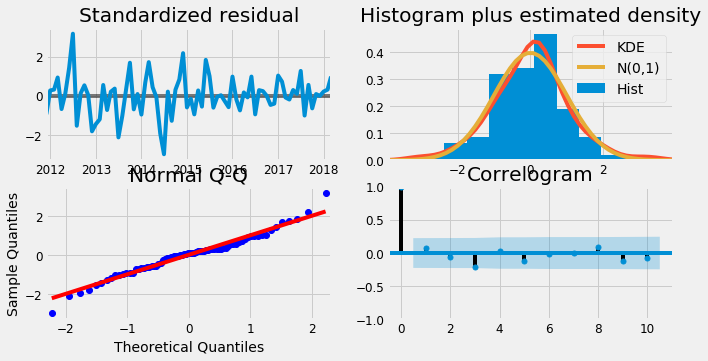

In [ ]:
# Model diagnostics(模型診斷)
# residual(殘差)是指依變項的觀察值與預測值之間的差距
results.plot_diagnostics(figsize=(10, 5))
plt.show()
# standardized residual 標準化殘差
# correlogram 相關圖 (y軸:ACF自相關係數，+1正相關，-1附相關，0沒相關 / x軸:不同階層的相關性)
# normal Q-Q plot (檢驗資料是否來自常態分佈) sample樣品/theoratical理論
# histogram plus estimated density 質方圖和預計密度

            lower close  upper close
2017-01-01   277.759125   468.517226
2017-02-01   308.450617   499.203652
2017-03-01   344.400314   535.148644
2017-04-01   338.170318   528.914278
2017-05-01   324.699518   515.439419
2017-06-01   356.558700   547.294830
2017-07-01   354.517669   545.250295
2017-08-01   387.018369   577.747740
2017-09-01   323.250049   513.976395
2017-10-01   370.472359   561.195894
2017-11-01   324.888252   515.609174
2017-12-01   327.803023   518.521518
2018-01-01   325.856348   516.572586
2018-02-01   345.937574   536.651715
2018-03-01   356.857014   547.569206
2018-04-01   411.745340   602.455720
2018-05-01   363.388231   642.565434
2018-06-01   354.649913   693.529972
2018-07-01   318.129144   712.978612
DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '201

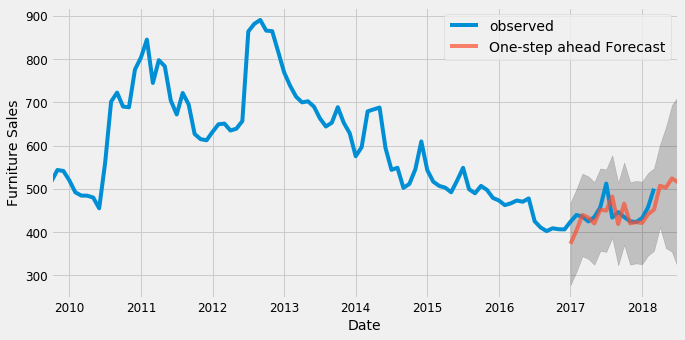

In [ ]:
# Real vs Forecast
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'),end=pd.to_datetime('2018-07-01'), dynamic=False) # 樣本內預測和樣本外預測(這邊屬於樣本內)
# dynamic (boolean，int，str或datetime) 整數偏移量相對於開始處開始動態預測。也可以是要解析的絕對日期字符串或日期時間類型（這些不被解釋為偏移量）。在此觀察之前，真正的內生值將用於預測; 從這一觀察開始並持續到預測結束，將使用預測的內生值
pred_ci = pred.conf_int() # 預測的信心區間
print(pred_ci)
print(pred_ci.index)
print(pred_ci.iloc[:, 0]) # column 1
print(pred_ci.iloc[:, 1]) # column 2
ax = dfts['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 5)) # 以ax為軸作圖 # 以平均值作圖
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2) # fill_between(填入顏色)，將信心區間最高最低的範圍用灰色表示 # iloc切片
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend() # 輸入圖形相關參數
plt.show()

In [ ]:
# MSE (均方誤差，越小越好)
y_forecasted = pred.predicted_mean
y_truth = dfts['2017-01-01':]
print(y_forecasted - y_truth)
mse = ((y_forecasted - y_truth) ** 2).mean() # MSE公式
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

2017-01-01   -50.943324
2017-02-01   -35.863918
2017-03-01     3.796218
2017-04-01     8.792824
2017-05-01   -14.930532
2017-06-01    -5.425507
2017-07-01   -62.509018
2017-08-01    48.736533
2017-09-01   -27.693278
2017-10-01    30.901854
2017-11-01    -4.864144
2017-12-01    -0.262730
2018-01-01   -11.237914
2018-02-01   -15.875810
2018-03-01   -48.411890
2018-04-01          NaN
2018-05-01          NaN
2018-06-01          NaN
2018-07-01          NaN
Freq: MS, dtype: float64
The Mean Squared Error of our forecasts is 998.38
